# 1.Import necessary libraries

In [2]:
import torch
from torch import nn
from transformers import RobertaConfig, RobertaModel, RobertaPreTrainedModel

class RobertaForAIViVN(RobertaPreTrainedModel):
    config_class = RobertaConfig
    base_model_prefix = "roberta"

    def __init__(self, config):
        super(RobertaForAIViVN, self).__init__(config)
        self.num_labels = config.num_labels
        self.roberta = RobertaModel(config)
        self.qa_outputs = nn.Linear(4*config.hidden_size, self.num_labels)

        self.init_weights()

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None,
                labels=None):
        outputs = self.roberta(input_ids,
                               attention_mask=attention_mask,
                               position_ids=position_ids,
                               head_mask=head_mask)
        cls_output = torch.cat((outputs.last_hidden_state[:,0, :],
                                outputs.hidden_states[-1][:,0, :],
                                outputs.hidden_states[-2][:,0, :],
                                outputs.hidden_states[-3][:,0, :]), -1)
        logits = self.qa_outputs(cls_output)

        # Tính toán loss nếu labels được cung cấp
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
            return loss, logits
        return logits


In [ ]:
import re
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from transformers import RobertaConfig, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity

from PhoBert.model import RobertaForAIViVN

ModuleNotFoundError: No module named 'RobertaForAIViVN'

# 2. Load data and Init model

In [2]:
df = pd.read_csv("Mobile_Phone.csv")

In [3]:
df.isnull().sum()

Product Name       0
Price              0
Image URL         21
Product URL        0
User Rating       21
Review Count       0
Specifications     0
Brand              0
Product ID         0
Category           0
dtype: int64

In [4]:
fill_values = {
    'User Rating': 0,
    'Image URL': 'No Image'
}

df.fillna(fill_values, inplace=True)

In [5]:
df.head()

,Product Name,Price,Image URL,Product URL,User Rating,Review Count,Specifications,Brand,Product ID,Category
0,Benco 4G G3,380.000₫,https://cdn.tgdd.vn/Products/Images/42/330485/...,https://www.thegioididong.com/dtdd/benco-4g-g3,3.7,3,{},Benco,330485,Điện thoại
1,HONOR X5 Plus 4GB/64GB,2.290.000₫,https://cdn.tgdd.vn/Products/Images/42/313306/...,https://www.thegioididong.com/dtdd/honor-x5-plus,3.7,12,"{'RAM': '4 GB', 'Dung lượng': '64 GB', 'Camera...",HONOR,313306,Điện thoại
2,HONOR X8b 8GB/512GB,6.390.000₫,https://cdn.tgdd.vn/Products/Images/42/324893/...,https://www.thegioididong.com/dtdd/honor-x8b,4.3,47,"{'RAM': '8 GB', 'Dung lượng': '512 GB', 'Camer...",HONOR,324893,Điện thoại
3,HONOR X7c 8GB/256GB,5.490.000₫,https://cdn.tgdd.vn/Products/Images/42/331512/...,https://www.thegioididong.com/dtdd/honor-x7c,0.0,0,"{'RAM': '8 GB', 'Dung lượng': '256 GB', 'Camer...",HONOR,331512,Điện thoại
4,HONOR X6b,3.690.000₫,https://cdn.tgdd.vn/Products/Images/42/327258/...,https://www.thegioididong.com/dtdd/honor-x6b-6...,4.0,4,"{'RAM': '6 GB', 'Dung lượng': '128 GB', 'Camer...",HONOR,327258,Điện thoại


In [6]:
df.columns

Index(['Product Name', 'Price', 'Image URL', 'Product URL', 'User Rating',
       'Review Count', 'Specifications', 'Brand', 'Product ID', 'Category'],
      dtype='object')

# 3. EDA (Exploratory Data Analysis)

C:\Users\Admin\AppData\Local\Temp\ipykernel_20868\1214322580.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=ratings, data=df, palette='viridis')


<Figure size 1200x600 with 0 Axes>

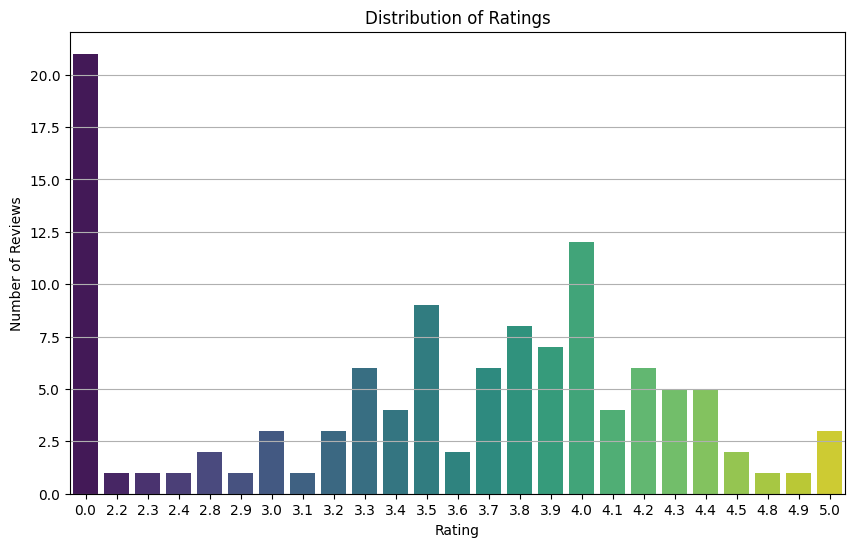

Rating trung bình: 3.094782608695652
Rating cao nhất: 5.0
Rating thấp nhất: 0.0


In [26]:
# Phân tích phân phối giá
def analyze_ratings():
    plt.figure(figsize=(12, 6))
    
    # Chuyển đổi giá từ string sang numeric
    ratings = df['User Rating']
    
    plt.figure(figsize=(10, 6))
    sns.countplot(x=ratings, data=df, palette='viridis')
    plt.title('Distribution of Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Number of Reviews')
    plt.grid(axis='y')
    plt.show()
    
    print(f"Rating trung bình: {ratings.mean()}")
    print(f"Rating cao nhất: {ratings.max()}")
    print(f"Rating thấp nhất: {ratings.min()}")
    
analyze_ratings()

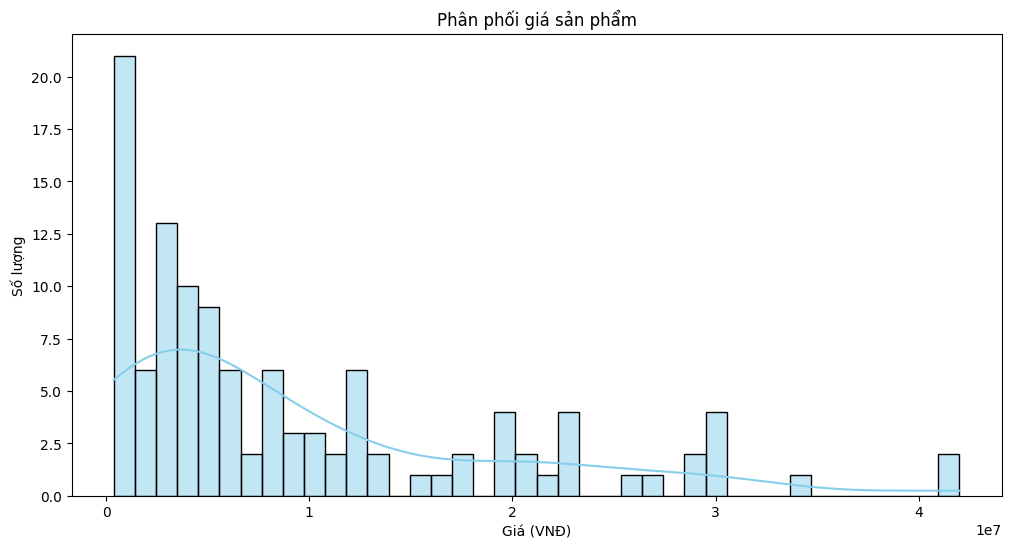

Giá trung bình: 9,411,739₫
Giá thấp nhất: 380,000₫
Giá cao nhất: 41,990,000₫


In [28]:
# Phân tích phân phối giá
def analyze_price_distribution():
    plt.figure(figsize=(12, 6))
    
    # Chuyển đổi giá từ string sang numeric
    prices = df['Price'].str.replace('₫','').str.replace('.','').astype(float)
    
    sns.histplot(data=prices, bins=40, kde=True, color='skyblue')
    plt.title('Phân phối giá sản phẩm')
    plt.xlabel('Giá (VNĐ)')
    plt.ylabel('Số lượng')
    plt.xticks()
    plt.show()  

    print(f"Giá trung bình: {prices.mean():,.0f}₫")
    print(f"Giá thấp nhất: {prices.min():,.0f}₫")
    print(f"Giá cao nhất: {prices.max():,.0f}₫")
analyze_price_distribution()

C:\Users\Admin\AppData\Local\Temp\ipykernel_20868\3209666663.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


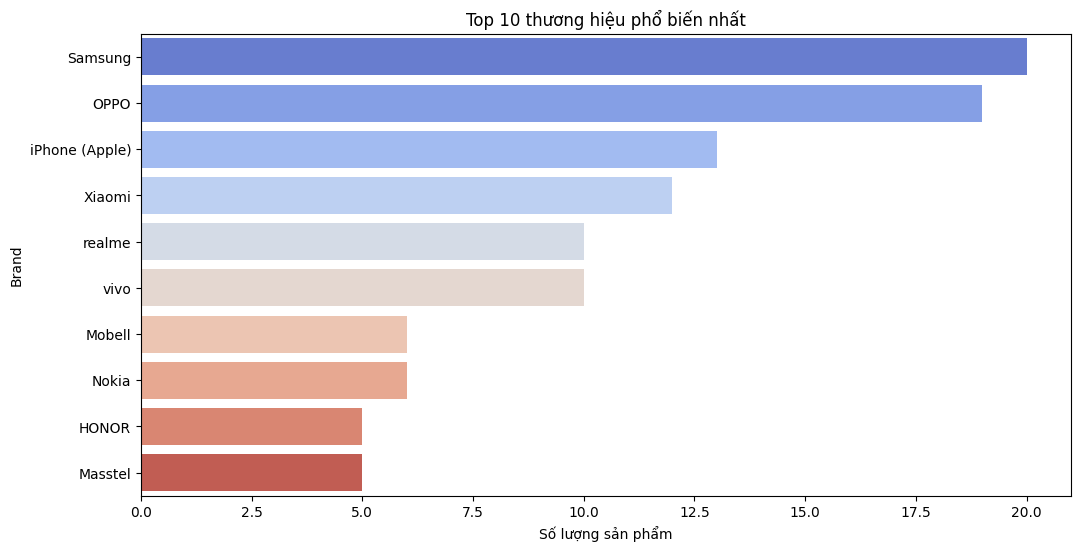

Tổng số thương hiệu: 15

Top 5 thương hiệu:
Brand
Samsung           20
OPPO              19
iPhone (Apple)    13
Xiaomi            12
realme            10


In [29]:
# Phân tích thương hiệu
def analyze_brands():
    plt.figure(figsize=(12, 6))
    brand_counts = df['Brand'].value_counts().head(10)
    
    sns.barplot(
            x=brand_counts.values,
            y=brand_counts.index, 
            palette='coolwarm')
    plt.title('Top 10 thương hiệu phổ biến nhất')
    plt.xlabel('Số lượng sản phẩm')
    plt.show()

    
    print(f"Tổng số thương hiệu: {df['Brand'].nunique()}")
    print("\nTop 5 thương hiệu:")
    print(brand_counts.head().to_string())

analyze_brands()


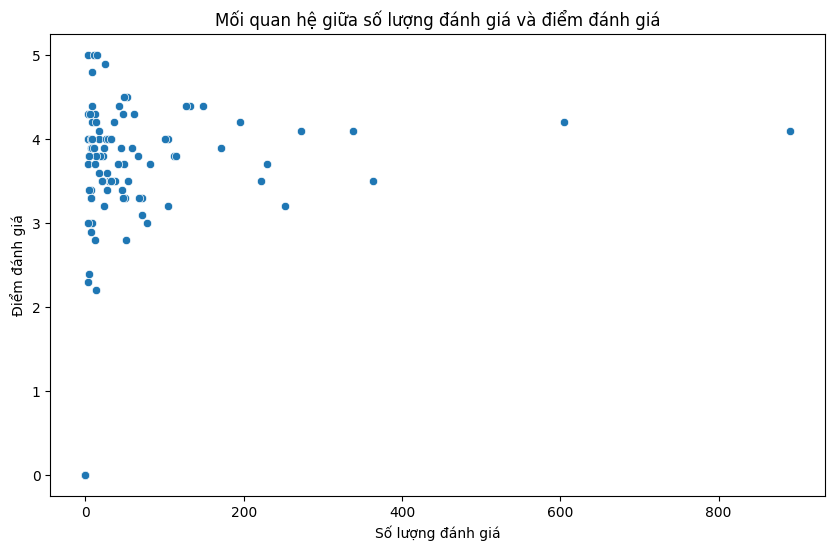


Thống kê đánh giá:
Điểm đánh giá trung bình: 3.09
Số lượng đánh giá trung bình: 57


In [9]:
# Phân tích mối quan hệ giữa đánh giá và số lượng review
def analyze_ratings():
    plt.figure(figsize=(10, 6))
    
    sns.scatterplot(data=df, x='Review Count', y='User Rating')
    plt.title('Mối quan hệ giữa số lượng đánh giá và điểm đánh giá')
    plt.xlabel('Số lượng đánh giá')
    plt.ylabel('Điểm đánh giá')
    plt.show()
    
    # In thống kê
    print("\nThống kê đánh giá:")
    print(f"Điểm đánh giá trung bình: {df['User Rating'].mean():.2f}")
    print(f"Số lượng đánh giá trung bình: {df['Review Count'].mean():.0f}")

analyze_ratings()


In [10]:
def parse_specifications(specs_str):
    """Phân tích chuỗi specifications thành dict"""
    try:
        specs_str = specs_str.strip()
        if not (specs_str.startswith('{') and specs_str.endswith('}')):
            return None
            
        specs_dict = {}
        specs_content = specs_str[1:-1]
        
        # Sử dụng regex để tách chuỗi một cách chính xác hơn
        pairs = re.findall(r"'([^']+)'\s*:\s*'([^']+)'", specs_content)
        
        for key, value in pairs:
            key = key.strip()
            value = value.strip()
            specs_dict[key] = value
                
        return specs_dict
    except Exception as e:
        print(f"Lỗi khi parse specifications: {e}")
        return None

def extract_product_features(row):
    """Trích xuất đặc trưng từ một sản phẩm"""
    try:
        specs_dict = parse_specifications(str(row['Specifications']))
        
        # Xử lý RAM và bộ nhớ
        if specs_dict:
            # Thêm xử lý default và kiểm tra giá trị
            ram_str = specs_dict.get('RAM', '0')
            storage_str = specs_dict.get('Dung lượng', '0')
            rear_camera_str = specs_dict.get('Camera sau', '0')
            front_camera_str = specs_dict.get('Camera trước', '0')
            
            # Xử lý RAM
            try:
                ram = int(re.search(r'\d+', ram_str).group())
            except:
                ram = 0
                
            # Xử lý bộ nhớ
            try:
                storage = int(re.search(r'\d+', storage_str).group())
            except:
                storage = 0

            # Xử lý camera
            try:
                rear_camera = int(re.search(r'\d+', rear_camera_str).group())
            except:
                rear_camera = 0

            try:
                front_camera = int(re.search(r'\d+', front_camera_str).group())
            except:
                front_camera = 0
        else:
            ram = storage = rear_camera = front_camera = 0
            
        return {
            'ram': ram,
            'storage': storage,
            'rear_camera': rear_camera,
            'front_camera': front_camera,
        }
    except Exception as e:
        print(f"Lỗi khi trích xuất đặc trưng: {e}")
        return None

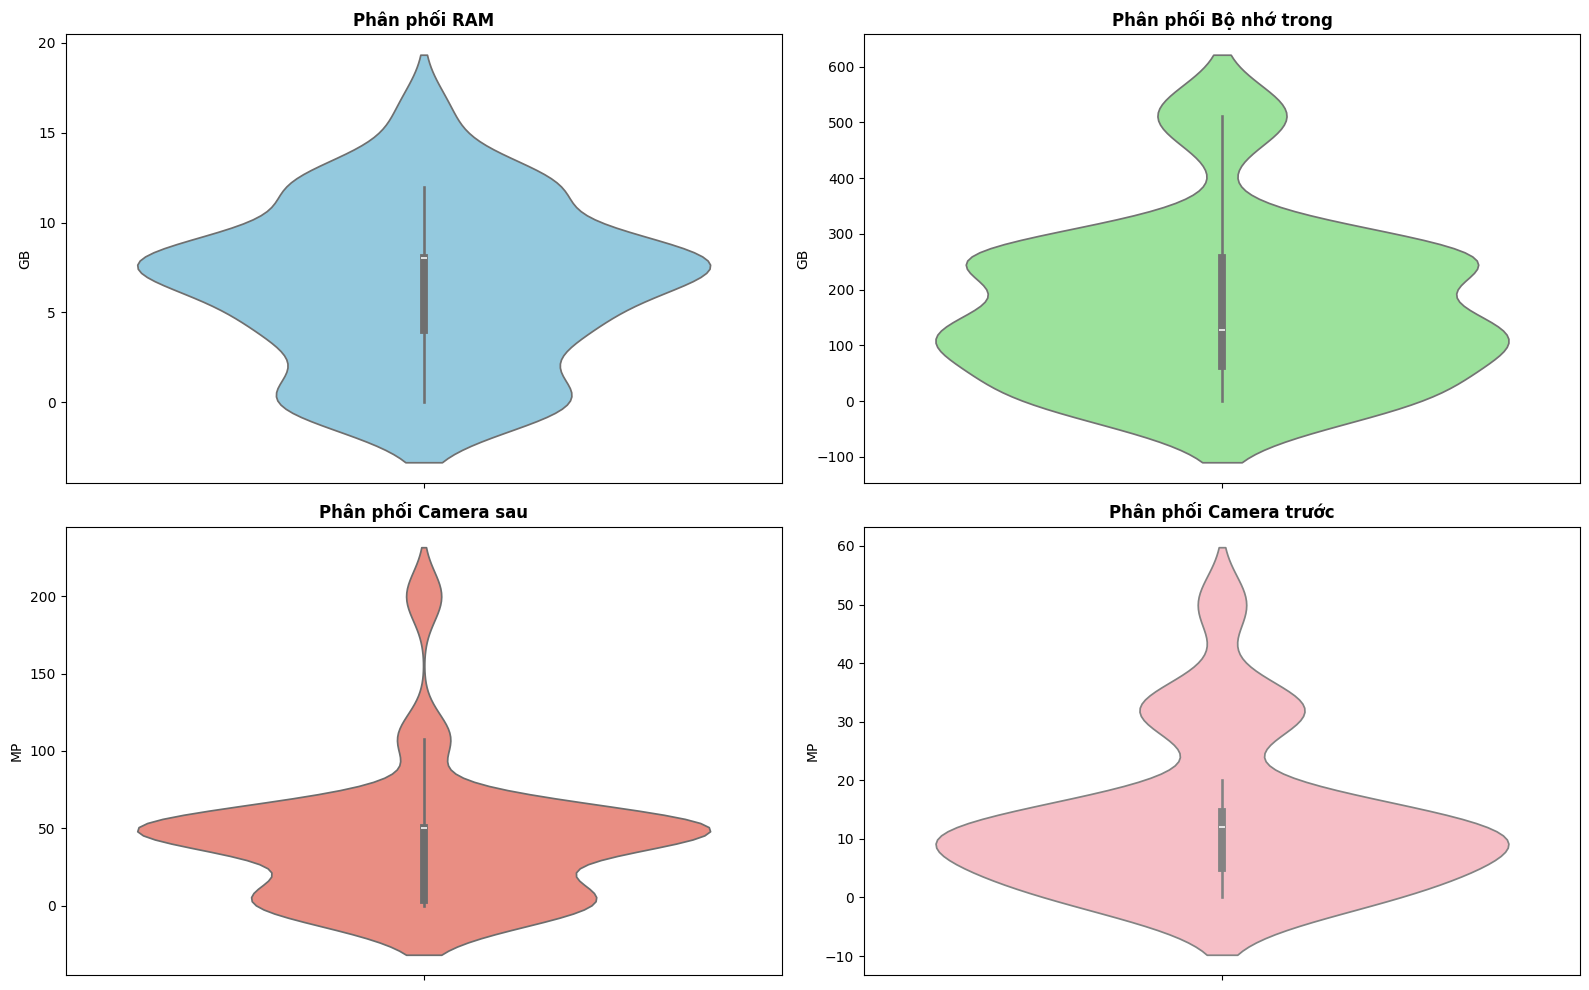


Thống kê cấu hình:
RAM trung bình: 6.5GB
Bộ nhớ trong trung bình: 170.9GB
Camera sau trung bình: 41.7MP
Camera trước trung bình: 13.2MP


,RAM,Storage,Rear Camera,Front Camera
0,0,0,0,0
1,4,64,50,5
2,8,512,108,50
3,8,256,108,8
4,6,128,50,5
...,...,...,...,...
110,12,512,50,32
111,6,128,50,13
112,12,512,50,32
113,6,128,108,13


In [11]:
def analyze_specs(df):
    specs_data = []
    for _, row in df.iterrows():
        features = extract_product_features(row)
        if features:
            specs_data.append({
                'RAM': features['ram'],
                'Storage': features['storage'],
                'Rear Camera': features['rear_camera'],
                'Front Camera': features['front_camera']
            })
    
    specs_df = pd.DataFrame(specs_data)
    
    plt.figure(figsize=(16, 10))
    
    plt.subplot(2, 2, 1)
    sns.violinplot(y=specs_df['RAM'], color='skyblue')
    plt.title('Phân phối RAM', fontweight='bold')
    plt.ylabel('GB')
    
    plt.subplot(2, 2, 2)
    sns.violinplot(y=specs_df['Storage'], color='lightgreen')
    plt.title('Phân phối Bộ nhớ trong', fontweight='bold')
    plt.ylabel('GB')
    
    plt.subplot(2, 2, 3)
    sns.violinplot(y=specs_df['Rear Camera'], color='salmon')
    plt.title('Phân phối Camera sau', fontweight='bold')
    plt.ylabel('MP')
    
    plt.subplot(2, 2, 4)
    sns.violinplot(y=specs_df['Front Camera'], color='lightpink')
    plt.title('Phân phối Camera trước', fontweight='bold')
    plt.ylabel('MP')
    
    plt.tight_layout()
    plt.show()
    
    print("\nThống kê cấu hình:")
    print(f"RAM trung bình: {specs_df['RAM'].mean():.1f}GB")
    print(f"Bộ nhớ trong trung bình: {specs_df['Storage'].mean():.1f}GB")
    print(f"Camera sau trung bình: {specs_df['Rear Camera'].mean():.1f}MP")
    print(f"Camera trước trung bình: {specs_df['Front Camera'].mean():.1f}MP")

    return specs_df

analyze_specs(df)


# 4. Function to Sentiment analysis

In [12]:
config = RobertaConfig.from_pretrained(
    "PhoBert/PhoBERT_base_transformers/config.json", from_tf=False, num_labels = 3, output_hidden_states=True,
)

model = RobertaForAIViVN(config)

model.load_state_dict(torch.load("PhoBert/Weights/model_weights.pth", map_location=torch.device('cpu')))
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")


def predict_sentiment(inputs):
    try:
        model.eval()
        with torch.no_grad():
            outputs = model(**inputs)
            if isinstance(outputs, torch.Tensor):
                logits = outputs
            else:
                logits = outputs.logits
            prediction = torch.argmax(logits, dim=1).item()
            return prediction
    except Exception as e:
        print(f"Lỗi khi dự đoán sentiment: {e}")
        return None

You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
C:\Users\Admin\AppData\Local\Temp\ipykernel_20868\532112039.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded f

In [13]:
def analyze_sentiment(text):
    """
    Phân tích cảm xúc từ văn bản
    """
    try:
        inputs = tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=256,
            return_tensors="pt"
        )
        sentiment = predict_sentiment(inputs)
        return sentiment
    except Exception as e:
        print(f"Lỗi khi phân tích cảm xúc: {e}")
        return None

# 5. Function to Processing product data


In [14]:
def parse_specifications(specs_str):
    """Phân tích chuỗi specifications thành dict"""
    try:
        specs_str = specs_str.strip()
        if not (specs_str.startswith('{') and specs_str.endswith('}')):
            return None
            
        specs_dict = {}
        specs_content = specs_str[1:-1]
        
        # Sử dụng regex để tách chuỗi một cách chính xác hơn
        pairs = re.findall(r"'([^']+)'\s*:\s*'([^']+)'", specs_content)
        
        for key, value in pairs:
            key = key.strip()
            value = value.strip()
            specs_dict[key] = value
                
        return specs_dict
    except Exception as e:
        print(f"Lỗi khi parse specifications: {e}")
        return None

def extract_product_features(row):
    """Trích xuất đặc trưng từ một sản phẩm"""
    try:
        specs_dict = parse_specifications(str(row['Specifications']))
        
        if specs_dict:
            # Thêm xử lý default và kiểm tra giá trị
            ram_str = specs_dict.get('RAM', '0')
            storage_str = specs_dict.get('Dung lượng', '0')
            rear_camera_str = specs_dict.get('Camera sau', '0')
            front_camera_str = specs_dict.get('Camera trước', '0')
            
            try:
                ram = int(re.search(r'\d+', ram_str).group())
            except:
                ram = 0
                
            try:
                storage = int(re.search(r'\d+', storage_str).group())
            except:
                storage = 0
            try:
                rear_camera = int(re.search(r'\d+', rear_camera_str).group())
            except:
                rear_camera = 0

            try:
                front_camera = int(re.search(r'\d+', front_camera_str).group())
            except:
                front_camera = 0
        else:
            ram = storage = rear_camera = front_camera = 0

        try:
            review_count = int(re.search(r'\d+', str(row['Review Count'])).group())
        except:
            review_count = 0
            
        try:
            price = float(str(row['Price']).replace('₫','').replace('.','').strip())
        except:
            price = 0
            
        try:
            rating = float(row['User Rating'])
        except:
            rating = 0.0
            
        return {
            'product_id': row['Product ID'],
            'price': price,
            'ram': ram,
            'storage': storage,
            'rear_camera': rear_camera,
            'front_camera': front_camera,
            'rating': rating,
            'review_count': review_count
        }
    except Exception as e:
        print(f"Lỗi khi trích xuất đặc trưng: {e}")
        return None

# 6. Function to Recommendation features


In [15]:
def create_recommendation_features(products_df):
    """Tạo ma trận đặc trưng cho hệ thống gợi ý"""
    numeric_features = ['price', 'ram', 'storage', 'rear_camera', 'front_camera', 'rating', 'review_count', 'sentiment']
    
    scaler = MinMaxScaler()
    products_df[numeric_features] = scaler.fit_transform(products_df[numeric_features])
    
    weights = {
        'sentiment': 0.25,
        'rating': 0.15,
        'price': 0.15,
        'ram': 0.1,
        'storage': 0.1,
        'rear_camera': 0.1,
        'front_camera': 0.05,
        'review_count': 0.1
    }
    
    weighted_features = products_df[list(weights.keys())].multiply(list(weights.values()))
    return weighted_features.values

def get_similar_products(product_id, features_matrix, products_df, n=5):
    try:
        product_id = int(product_id)
        product_idx = products_df[products_df['product_id'] == product_id].index[0]
        
        similarities = cosine_similarity([features_matrix[product_idx]], features_matrix)
        similar_indices = similarities[0].argsort()[::-1][1:n+1]
        
        result = products_df.iloc[similar_indices].copy()
        result['similarity_score'] = similarities[0][similar_indices]
        
        return result
    except Exception as e:
        print(f"Lỗi khi tìm sản phẩm tương tự: {e}")
        return None

# 7. Function that combines Sentiment analysis and Recommendation

In [16]:
def analyze_review_and_recommend(review_text, product_id, df, n=5):
    """Phân tích cảm xúc và gợi ý sản phẩm"""
    try:
        sentiment = analyze_sentiment(review_text)
        sentiment_text = 'Tiêu cực' if sentiment == 0 else 'Trung tính' if sentiment == 1 else 'Tích cực'
        print(f"Cảm xúc được phân tích: {sentiment_text}")
        
        # Nếu cảm xúc tiêu cực, không đưa ra gợi ý
        if sentiment == 0:
            return None, sentiment
            
        products_features = []
        for _, row in df.iterrows():
            features = extract_product_features(row)
            if features:
                features['sentiment'] = sentiment if row['Product ID'] == product_id else 1
                products_features.append(features)
        
        products_df = pd.DataFrame(products_features)
        features_matrix = create_recommendation_features(products_df)
        recommendations = get_similar_products(product_id, features_matrix, products_df, n)
        
        return recommendations, sentiment
        
    except Exception as e:
        print(f"Lỗi trong quá trình phân tích và gợi ý: {e}")
        return None, None

In [19]:
def demo_system():
    test_id = '326477'
    test_review = "Điện thoại bình thường, camera trước sau tạm ổn, pin oke"
    
    print("Bình luận:", test_review)
    print("ID sản phẩm:", test_id)
    
    recommendations, sentiment = analyze_review_and_recommend(test_review, test_id, df)
    
    if recommendations is not None:
        print("\nSản phẩm được gợi ý:")
        for _, rec in recommendations.iterrows():
            product_info = df[df['Product ID'] == rec['product_id']].iloc[0]
            print("\n-----------------------------------")
            print(f"Tên sản phẩm: {product_info['Product Name']}")
            print(f"Giá: {product_info['Price']}")
            print(f"Link sản phẩm: {product_info['Product URL']}")
            print(f"Độ tương đồng: {rec['similarity_score']:.2f}")
    else:
        print("Không tìm thấy gợi ý phù hợp")

# Chạy demo
demo_system()

Bình luận: Điện thoại bình thường, camera trước sau tạm ổn, pin oke
ID sản phẩm: 326477
Cảm xúc được phân tích: Trung tính

Sản phẩm được gợi ý:

-----------------------------------
Tên sản phẩm: Nokia 220 4G
Giá: 990.000₫
Link sản phẩm: https://www.thegioididong.com/dtdd/nokia-220-4g
Độ tương đồng: 1.00

-----------------------------------
Tên sản phẩm: Nokia 110 4G Pro
Giá: 750.000₫
Link sản phẩm: https://www.thegioididong.com/dtdd/nokia-110-4g-pro
Độ tương đồng: 1.00

-----------------------------------
Tên sản phẩm: Masstel Fami 60S 4G
Giá: 700.000₫
Link sản phẩm: https://www.thegioididong.com/dtdd/masstel-fami-60s
Độ tương đồng: 1.00

-----------------------------------
Tên sản phẩm: Itel it9310
Giá: 650.000₫
Link sản phẩm: https://www.thegioididong.com/dtdd/itel-it9310
Độ tương đồng: 1.00

-----------------------------------
Tên sản phẩm: Nokia HMD 105 4G
Giá: 650.000₫
Link sản phẩm: https://www.thegioididong.com/dtdd/nokia-hmd-105-4g
Độ tương đồng: 1.00
